In [58]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [59]:
#Checking wich GPU is beeing used

!nvidia-smi

Thu Dec  9 16:41:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   32C    P8    16W / 250W |   2203MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [60]:
#Load data
data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/whole_second/mfcc/less_20_5_speaker1.npy'

data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/whole_second/mfcc/less_20_5_speaker2.npy'

labels_dir = 'dialogue/Dataset/SameVoiceDetection/whole_second/mfcc/less_20_5_labels.npy'


data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
#data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
#data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels)

(3200, 40, 32) (3200, 40, 32)
[ True False  True ... False  True False]


In [61]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_val, y_train, y_val = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_test, y_train, y_test = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_val, y_train, y_val = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_test, y_train, y_test = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [62]:
X1_train = torch.from_numpy(X1_train).float()

X2_train = torch.from_numpy(X2_train).float()

y_train = torch.from_numpy(y_train).float()

X1_val = torch.from_numpy(X1_val).float()

X2_val = torch.from_numpy(X2_val).float()

y_val = torch.from_numpy(y_val).float()

X1_test = torch.from_numpy(X1_test).float()

X2_test = torch.from_numpy(X2_test).float()

y_test = torch.from_numpy(y_test).float()

print(X2_train.shape, y_train.shape)

print(X2_train[0])


torch.Size([2048, 40, 32]) torch.Size([2048])
tensor([[-3.0958e+02, -3.0465e+02, -2.8005e+02,  ..., -2.9558e+02,
         -3.4148e+02, -3.8393e+02],
        [ 1.1720e+02,  8.0796e+01,  4.0841e+00,  ..., -6.5969e+01,
         -1.9079e+01,  6.7351e+01],
        [-1.3757e+01,  1.4735e+01,  8.2026e+01,  ...,  6.8309e+01,
          8.1536e+01,  8.1149e+01],
        ...,
        [-3.6334e+00, -8.8756e+00, -8.0924e+00,  ..., -7.7838e+00,
          2.2948e-01,  3.3340e+00],
        [-7.4565e+00, -8.4321e+00, -1.2831e+01,  ..., -3.3749e+00,
         -2.7882e-01,  3.5406e-01],
        [-1.7537e+00, -5.9824e+00, -8.8652e+00,  ...,  1.8182e+00,
         -1.1507e+00, -5.7950e-02]])


In [63]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=3, stride = 1) #40 input channels, 40 output channels
        self.conv2 = nn.Conv1d(40, 60, kernel_size=3, stride = 1) #40 input channels from previous Conv. layer, 80 out
        self.conv3 = nn.Conv1d(60, 80, kernel_size=3, stride = 1)

        self.fc1 = nn.Linear(320, 200) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        
        x = x.reshape(len(x), -1)
        batch_size = len(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

In [64]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [65]:
train_ds = TensorDataset(X1_train, X2_train, y_train)
val_ds = TensorDataset(X1_val, X2_val, y_val)

In [66]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X1_train = X1_train.to(device)
# X2_train = X2_train.to(device)
# y_train = y_train.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)

X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)

CNN = CNN.to(device)
criterion = criterion.to(device)
print(device)

cuda


In [68]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [69]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)
    
Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val', 'val_loss', 'train_loss'])
    
for epoch in range(50):
    y_acc = torch.empty((batch_size),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((batch_size), device = 'cuda')
    for x1, x2, y in train_dl:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = CNN(x1, x2)
        y_pred = y_pred.squeeze()
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
    if epoch % 1 == 0:


        train_acc = calculate_accuracy(y_acc, CNN.post_forward(y_pred_acc))
    
        y_val_pred = CNN(X1_val, X2_val)
        y_val_pred = y_val_pred.squeeze()
        val_loss = criterion(y_val_pred, y_val)
    
        val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
    
        result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc), 'val_loss': round_tensor(val_loss), 'train_loss': round_tensor(train_loss)}

        Results = Results.append(result, ignore_index=True)

        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')

epoch 0
Train set - loss: 0.696, accuracy: 0.491
val  set - loss: 0.698, accuracy: 0.459

epoch 1
Train set - loss: 0.69, accuracy: 0.502
val  set - loss: 0.697, accuracy: 0.488

epoch 2
Train set - loss: 0.686, accuracy: 0.52
val  set - loss: 0.697, accuracy: 0.473

epoch 3
Train set - loss: 0.685, accuracy: 0.527
val  set - loss: 0.697, accuracy: 0.488

epoch 4
Train set - loss: 0.684, accuracy: 0.541
val  set - loss: 0.698, accuracy: 0.489

epoch 5
Train set - loss: 0.683, accuracy: 0.551
val  set - loss: 0.699, accuracy: 0.48

epoch 6
Train set - loss: 0.682, accuracy: 0.553
val  set - loss: 0.699, accuracy: 0.48

epoch 7
Train set - loss: 0.679, accuracy: 0.563
val  set - loss: 0.7, accuracy: 0.473

epoch 8
Train set - loss: 0.678, accuracy: 0.573
val  set - loss: 0.7, accuracy: 0.469

epoch 9
Train set - loss: 0.676, accuracy: 0.58
val  set - loss: 0.7, accuracy: 0.463

epoch 10
Train set - loss: 0.675, accuracy: 0.583
val  set - loss: 0.701, accuracy: 0.466

epoch 11
Train set -

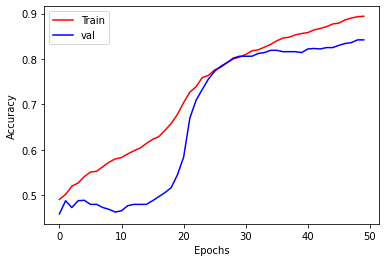

    Epoch  Acc_train  Acc_val  val_loss  train_loss
0     0.0      0.491    0.459     0.698       0.696
1     1.0      0.502    0.488     0.697       0.690
2     2.0      0.520    0.473     0.697       0.686
3     3.0      0.527    0.488     0.697       0.685
4     4.0      0.541    0.489     0.698       0.684
5     5.0      0.551    0.480     0.699       0.683
6     6.0      0.553    0.480     0.699       0.682
7     7.0      0.563    0.473     0.700       0.679
8     8.0      0.573    0.469     0.700       0.678
9     9.0      0.580    0.463     0.700       0.676
10   10.0      0.583    0.466     0.701       0.675
11   11.0      0.591    0.477     0.701       0.672
12   12.0      0.598    0.480     0.702       0.670
13   13.0      0.604    0.480     0.702       0.667
14   14.0      0.614    0.480     0.702       0.664
15   15.0      0.623    0.488     0.701       0.660
16   16.0      0.629    0.497     0.700       0.658
17   17.0      0.643    0.506     0.699       0.654
18   18.0   

In [70]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_val,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

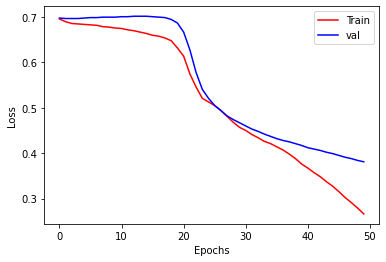

In [71]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.val_loss,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [72]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.90      0.77      0.83       322
     Same Voice       0.80      0.92      0.85       318

       accuracy                           0.84       640
      macro avg       0.85      0.84      0.84       640
   weighted avg       0.85      0.84      0.84       640



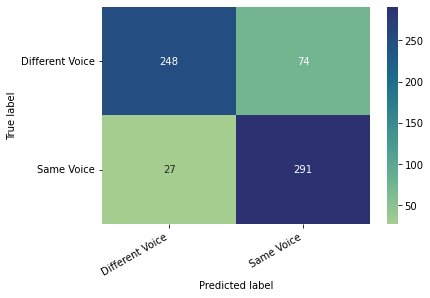

In [73]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [74]:
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.91      0.80      0.85       263
     Same Voice       0.81      0.91      0.86       249

       accuracy                           0.85       512
      macro avg       0.86      0.86      0.85       512
   weighted avg       0.86      0.85      0.85       512



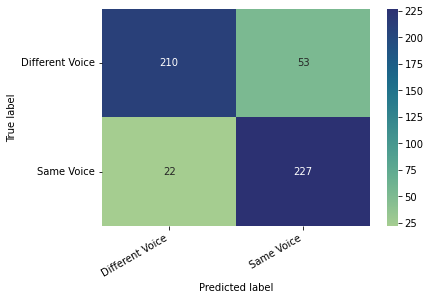

In [75]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [76]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
